# Imports

In [3]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [4]:
import os
import numpy as np
import tensorflow as tf
import itertools

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from tensorflow.keras.utils import array_to_img
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

# Constants

In [5]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [7]:
type(cifar10)
type(x_train_all)

numpy.ndarray

# Explore the Data

In [8]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

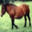

In [9]:
pic = array_to_img(x_train_all[7])
display(pic)

In [10]:
y_train_all.shape

(50000, 1)

In [11]:
y_train_all[7][0]

7

In [12]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

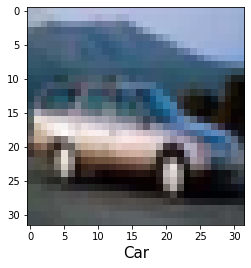

In [13]:
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]], fontsize=15)
plt.show()

**Challenge:** Write a for loop to display the first 10 images from the x_train_all array in a row. Show the name of the label below the picture. Remove the ugly tick marks. Hint use matplotlib.

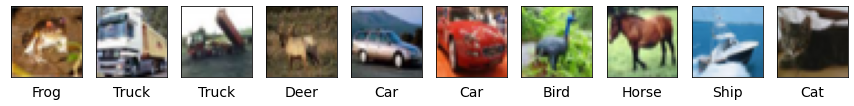

In [14]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=14)
    plt.imshow(x_train_all[i])

In [15]:
x_train_all[0].shape

(32, 32, 3)

In [16]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width ={x} \t| height = {y} \t| channels ={c}')

images = 50000 	| width =32 	| height = 32 	| channels =3


In [17]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [18]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [19]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

In [20]:
type(x_train_all[0][0][0][0])

numpy.float64

In [21]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

In [22]:
x_train_all.shape

(50000, 3072)

In [23]:
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


### Create Validation Dataset

In [24]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

**Challenge**: Create two numpy x_train and y_train that have the shape (40000, 3072) and (40000, 1) respectively. They need to contain the last 40000 values from x_train_all and y_train_all respectively.

In [25]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

### Create a small dataset (for illustration)

In [26]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [27]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=64, activation='relu', name='m1_hidden2'),
    Dense(16, activation='relu', name='m1_hidden3'),
    Dense(10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

2023-02-03 16:14:43.218971: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [29]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m2_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

In [30]:
type(model_1)

keras.engine.sequential.Sequential

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [32]:
32*32*3*128 + 128 + (128*64 + 64) + (64*16 + 16) + (16*10 + 10)

402810

# Tensorboard (visualising learning)

In [33]:
def get_tensorboard(model_name):
    
    folder_name = f'{model_name} at {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

# Fit the Model

In [34]:
samples_per_batch = 1000

In [37]:
# %%time
# nr_epochs = 150
# model_1.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
#             callbacks=[get_tensorboard('Model 1')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory


2023-02-03 16:16:30.063169: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:16:30.063424: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:16:30.064932: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:16:30.193547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-03 16:16:31.629178: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:16:31.629408: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:16:31.658805: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-03 16:16:31.665173: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:16:31.677242: I tensorflow/core/profile

CPU times: user 1min 11s, sys: 1.77 s, total: 1min 13s
Wall time: 30.7 s


In [38]:
# %%time
# nr_epochs = 150
# model_2.fit(x_train_xs, y_train_xs, batch_size=samples_per_batch, epochs=nr_epochs, 
#             callbacks=[get_tensorboard('Model 2')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory


2023-02-03 16:17:00.805708: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:17:00.805765: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:17:00.806764: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:17:01.826803: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:17:01.826865: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:17:01.894946: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-03 16:17:01.896303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:17:01.898143: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard_cifar_logs/Model 2 at 16 17/train/plugins/profile/2023_02_03_16_17_01

2023-02-03 16:17:01

CPU times: user 1min 18s, sys: 1.57 s, total: 1min 19s
Wall time: 32.7 s


In [39]:
%%time
nr_epochs = 100
model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 1 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory


2023-02-03 16:17:35.849226: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:17:35.849313: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:17:35.849683: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:17:36.876244: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:17:36.876462: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:17:36.906539: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-03 16:17:36.907556: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:17:36.909075: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard_cifar_logs/Model 1 XL at 16 17/train/plugins/profile/2023_02_03_16_17_36

2023-02-03 16:17

CPU times: user 6min 10s, sys: 7.27 s, total: 6min 17s
Wall time: 2min 22s


In [40]:
%%time
nr_epochs = 100
model_2.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 2 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory


2023-02-03 16:19:58.761812: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:19:58.761895: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:19:58.762465: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:19:59.735794: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:19:59.735849: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:19:59.778761: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-03 16:19:59.779881: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:19:59.781270: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard_cifar_logs/Model 2 XL at 16 19/train/plugins/profile/2023_02_03_16_19_59

2023-02-03 16:19

CPU times: user 9min 29s, sys: 9.07 s, total: 9min 38s
Wall time: 3min 9s


In [41]:
%%time
nr_epochs = 100
model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard('Model 3 XL')], verbose=0, validation_data=(x_val, y_val))

Successfully created directory


2023-02-03 16:23:08.634976: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:23:08.635203: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:23:08.635638: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:23:10.322879: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-03 16:23:10.323104: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-03 16:23:10.385991: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-03 16:23:10.387398: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-03 16:23:10.389160: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorboard_cifar_logs/Model 3 XL at 16 23/train/plugins/profile/2023_02_03_16_23_10

2023-02-03 16:23

CPU times: user 9min 42s, sys: 10.1 s, total: 9min 52s
Wall time: 3min 7s


# Predictions on Individual Images

In [42]:
x_val.shape

(10000, 3072)

In [43]:
x_val[0]

array([0.23137255, 0.24313725, 0.24705882, ..., 0.48235294, 0.36078431,
       0.28235294])

In [44]:
x_val[0].shape

(3072,)

In [45]:
test = np.expand_dims(x_val[0], axis=0)
test.shape

(1, 3072)

In [46]:
np.set_printoptions(precision=3)

In [47]:
model_2.predict(test)

array([[0.057, 0.011, 0.079, 0.11 , 0.343, 0.069, 0.29 , 0.033, 0.006,
        0.001]], dtype=float32)

In [48]:
model_2.predict(test).sum()

0.9999999

In [49]:
model_2.predict(x_val)

array([[5.676e-02, 1.114e-02, 7.900e-02, ..., 3.260e-02, 6.120e-03,
        1.455e-03],
       [4.355e-03, 5.676e-01, 5.654e-04, ..., 2.841e-03, 1.799e-02,
        4.039e-01],
       [1.856e-02, 8.181e-02, 8.594e-03, ..., 3.016e-02, 1.983e-02,
        8.189e-01],
       ...,
       [1.313e-02, 2.753e-01, 1.252e-03, ..., 2.731e-02, 6.898e-02,
        5.874e-01],
       [1.434e-01, 3.107e-01, 9.893e-02, ..., 7.186e-02, 4.160e-03,
        3.020e-01],
       [1.364e-03, 2.581e-05, 8.960e-02, ..., 4.708e-01, 1.414e-04,
        2.905e-04]], dtype=float32)

In [50]:
model_2.predict(x_val).shape

(10000, 10)

In [51]:
np.argmax(model_2.predict(test), axis=1)

array([4])

In [52]:
y_val[0]

array([6], dtype=uint8)

**Challenge:** Write a for loop where you print out the actual value and the predicted value for the fitst 10 images in the valuation dataset.

In [53]:
predictions = np.array([ np.argmax(prediction) for prediction in model_2.predict(x_test) ])

# Evaluation

In [54]:
model_2.metrics_names

['loss', 'accuracy']

In [55]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

313/313 [==============================] - 1s 3ms/step - loss: 1.4271 - accuracy: 0.4902
Test loss is 1.43 and test accuracy is 49.0%


### Confusion Matrix

In [56]:
predictions = np.array([ np.argmax(prediction) for prediction in model_2.predict(x_test) ])
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [57]:
conf_matrix.shape

(10, 10)

In [62]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [63]:
conf_matrix.max()

695

In [64]:
conf_matrix.min()

6

In [65]:
conf_matrix[0]

array([584,  29,  64,  17,  61,   8,  23,  30, 159,  25])

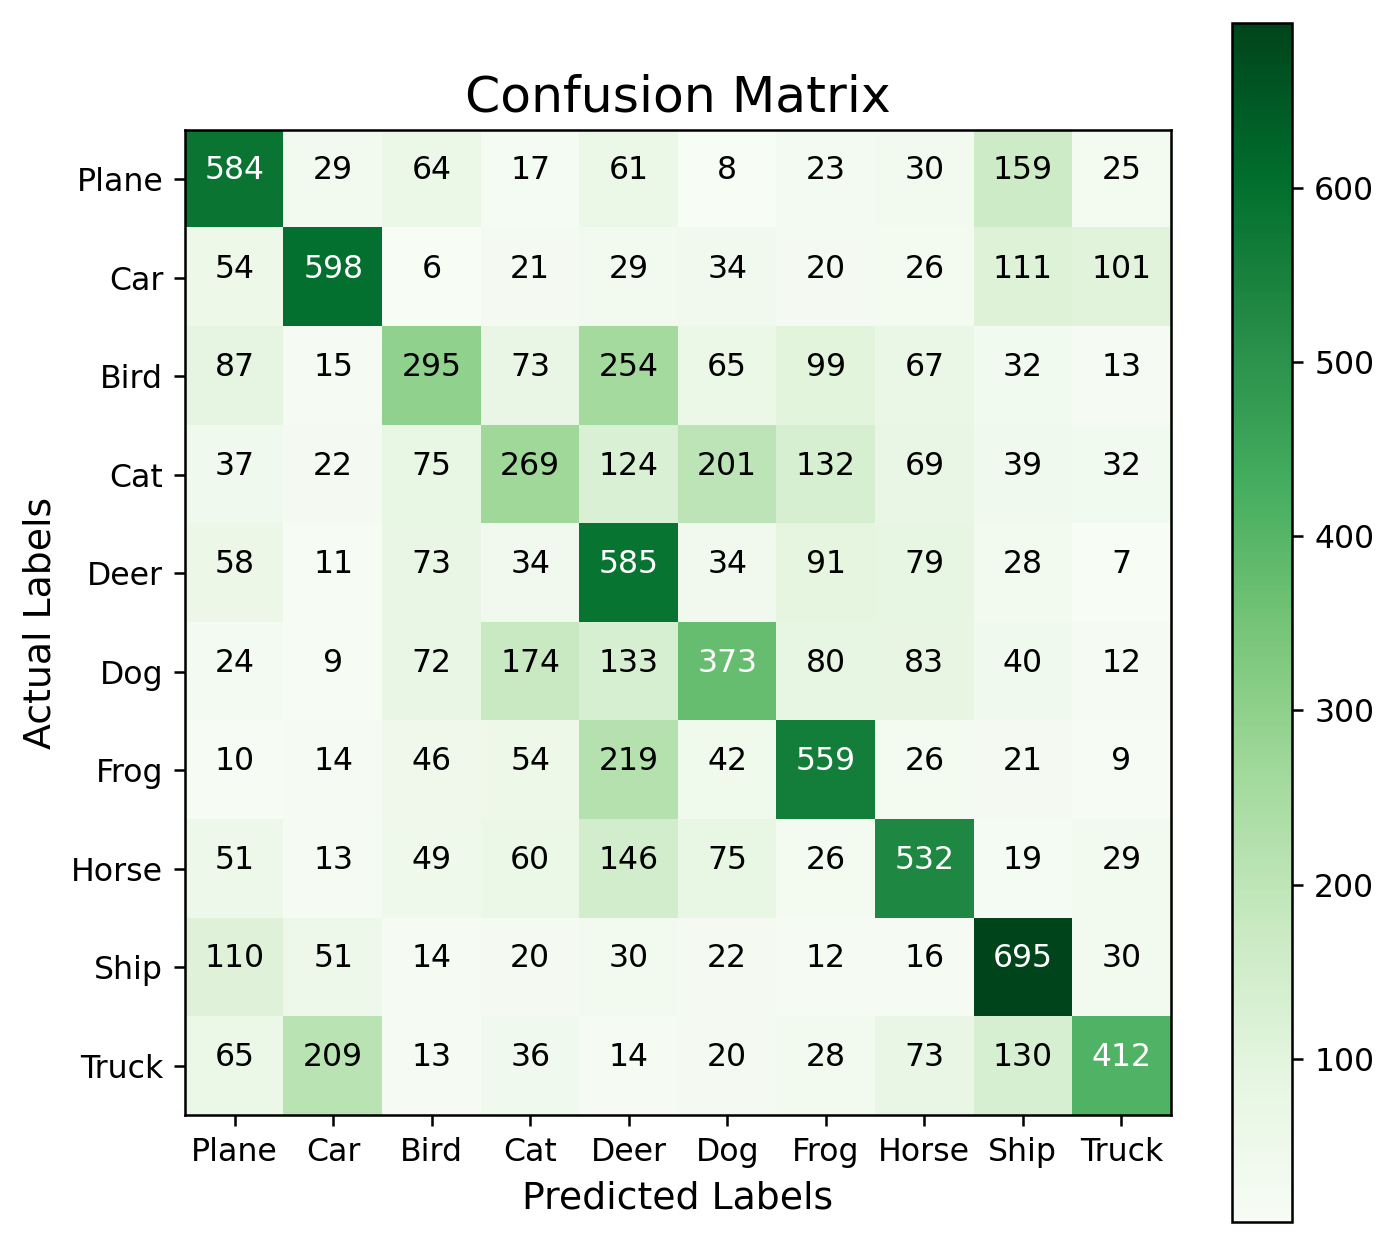

In [66]:
plt.figure(figsize=(7,7), dpi=227)
plt.imshow(conf_matrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')
    
plt.show()

**Challenge:** What do the numbers down the diagonal represent? What do the other numbers (excluding the number in the diagonal) in a single row represent? Try to identify the false positives, false negatives, and the true positives in the confusion matrix.

In [67]:
# True Positives
np.diag(conf_matrix)

array([584, 598, 295, 269, 585, 373, 559, 532, 695, 412])

In [68]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.584, 0.598, 0.295, 0.269, 0.585, 0.373, 0.559, 0.532, 0.695,
       0.412])

In [69]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.541, 0.616, 0.417, 0.355, 0.367, 0.427, 0.522, 0.531, 0.546,
       0.615])

In [70]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 49.02%


**Challenge:** Calculate the average precision for the model as a whole. Print this out. Then calculate the f-score for the model as a whole.

In [71]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 2 f score is {f1_score:.2%}')

Model 2 precision score is 49.37%
Model 2 f score is 49.19%


# Resource

https://www.udemy.com/course/python-data-science-machine-learning-bootcamp